# Determining Moore's Law with real data in NumPy

## What you'll do

In this tutorial, we will use NumPy to perform linear regression on semiconductor manufacturing data. Gordon Moore predicted that the rate of semiconductors on a computer chip would double every two years in the decade from 1965 - 1975 [[1](https://en.wikipedia.org/wiki/Moore%27s_law),[2](https://newsroom.intel.com/wp-content/uploads/sites/11/2018/05/moores-law-electronics.pdf)]. In 2015, Moore revised his prediction to say Moore's law should only hold until 2025 [[3](https://spectrum.ieee.org/computing/hardware/gordon-moore-the-man-whose-name-means-progress)]. 

We will determine the best-fit constants to describe the exponential growth of transistors on semiconductors compared to Moore's Law.

## What you'll learn

- You'll use linear regression to predict exponential growth
- You'll learn to load data from a comma separated values (\*.csv) file
- You'll compare exponential growth constants between models
- You'll share your analysis as NumPy zipped files (\*.npz) 
- You'll share your analysis as a \*.csv file
- You'll assess the amazing progress semiconductor manufacturers have made in the last five decades

## What you'll need

First, you need to import our necessary libraries:

* NumPy
* Matplotlib
* statsmodels ordinary linear regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In this tutorial, we will use the following NumPy and Matplotlib tools:

* `np.loadtxt` : this function loads text into a NumPy array
* `np.log` : this function takes the natural log of a NumPy array
* `plt.semilogy` : this function will plot x-y data onto a figure with a linear x-axis and $\log_{10}$ y-axis
* `sm.OLS` : the statsmodels ordinary least squares model creates a statistical model that can be used to find fitting parameters and their standard errors plus more
* slicing arrays: to view parts of the data we load into the workspace, we will slice the arrays e.g. `x[:10]` will give us the first 10 values in the array, `x`
* boolean array indexing: to view parts of the data that match a given condition we will use boolean operations to index an array
* `np.savez` and `np.savetxt`: these two function will save our arrays in zipped array format and text, respectively

In addition to these skills, we are using exponential growth to describe transistors on semiconductor chips. So, you need a little background in doing math with [natural logs](https://en.wikipedia.org/wiki/Natural_logarithm) and [exponentials](https://en.wikipedia.org/wiki/Exponential_function). 

***

## Building Moore's law as an exponential function

Our empirical model assumes that the number of transistors per semiconducter follows an exponential growth,  

$log(transistor~count)= f(year) = A\cdot year+B,$

where $A$ and $B$ are fitting constants that are determined using semiconductor manufacturers' data. 

These constants for Moore's law are determined by specifying the rate that transistors are added, 2, and giving an initial number of transistors for a given year. 

Moore's law in our exponential form is stated as follows, 

$transistor~count= e^{A_M\cdot year +B_M}.$

Where $A_M$ and $B_M$ are constants that double the number of transistors every two years and start at 2250 transistors in 1971,

1. $\frac{transistor\_count(year +2)}{transistor\_count(year)} = 2 = \frac{e^{B_M}e^{A_M year + 2A_M}}{e^{B_M}e^{A_M year}} = e^{2A_M} \rightarrow A_M = \log(2)/2$

2. $\log(2250) = \log(2)/2\cdot 1971 + B_M \rightarrow B_M = \log(2250)-\log(2)/2\cdot 1971$

so Moore's law stated as an exponential function is

$log(transistor~count)= A_M\cdot year+B_M,$

where

$A_M=0.3466$

$B_M=-675.4$

Since we have a function to represent Moore's law, we can define it as a Python function

In [2]:
A_M = np.log(2)/2
B_M = np.log(2250) - A_M*1971
Moores_law = lambda year: np.exp(B_M)*np.exp(A_M*year)

In 1971, there were 2250 transistors on the Intel 4004 chip. We can use `Moores_law` to check how many semiconductors Gordon Moore would expect in 1973.

In [3]:
ML_1971 = Moores_law(1971)
ML_1973 = Moores_law(1973)
print('In 1973, G. Moore expects {:.0f} transistors on Intels chips'.format(ML_1973))
print('This is x{:.2f} more transistors than 1971'.format(ML_1973/ML_1971))

In 1973, G. Moore expects 4500 transistors on Intels chips
This is x2.00 more transistors than 1971


## Loading historical manufacturing data to our workspace

Now, we want to make a prediction based upon the historical data for semiconductors per chip. The `transistor_data.csv` was downloaded from the Wikipedia page for [Transistor Count \[4\]](https://en.wikipedia.org/wiki/Transistor_count#Microprocessors). Before loading a \*.csv file into a NumPy array, its a good idea to inspect the structure of the file first. Then, locate the columns of interest and save them to a variable. We will save two columns of the file to the array, `data`.

Here, we print out the first 10 rows of `transistor_data.csv`. The columns are 

|Processor|MOS transistor count|Date of Introduction|Designer|MOSprocess|Area|
|---|---|---|---|---|---|
|Intel 4004 (4-bit  16-pin)|2250|1971|Intel|"10,000 nm"|12 mm²|
|...|...|...|...|...|...|

In [4]:
! head transistor_data.csv

Processor,MOS transistor count,Date of Introduction,Designer,MOSprocess,Area
Intel 4004 (4-bit  16-pin),2250,1971,Intel,"10,000 nm",12 mm²
Intel 8008 (8-bit  18-pin),3500,1972,Intel,"10,000 nm",14 mm²
NEC μCOM-4 (4-bit  42-pin),2500,1973,NEC,"7,500 nm",?
Intel 4040 (4-bit  16-pin),3000,1974,Intel,"10,000 nm",12 mm²
Motorola 6800 (8-bit  40-pin),4100,1974,Motorola,"6,000 nm",16 mm²
Intel 8080 (8-bit  40-pin),6000,1974,Intel,"6,000 nm",20 mm²
TMS 1000 (4-bit  28-pin),8000,1974,Texas Instruments,"8,000 nm",11 mm²
MOS Technology 6502 (8-bit  40-pin),4528,1975,MOS Technology,"8,000 nm",21 mm²
Intersil IM6100 (12-bit  40-pin; clone of PDP-8),4000,1975,Intersil,,


We don't need the columns that specify __Processor__, __Designer__, __MOSprocess__, or __Area__, so that leaves the second and third columns, __MOS transistor count__ and __Date of Introduction__, respectively.

Next, we load these two columns into a NumPy array using `np.loadtxt`. There are extra options to get the data in the desired format:

* `delimiter = ','`: specify delimeter as a comma ',' (this is the default behavior)
* `usecols = [1,2]`: only import the second and third columns from the csv
* `skiprows = 1`: do not use the first row, because its a header row

In [5]:
data = np.loadtxt('./transistor_data.csv', 
                  delimiter=',', 
                  usecols=[1,2], 
                  skiprows=1)

The entire history of semiconducting is loaded into a NumPy array named `data`. The first column is the __MOS transistor count__ and the second column is the __Date of Introduction__ in a four-digit year. 

Next, we make our data easier to read and manage by assigning the two columns to variables, `year` and `transistor_count`. Print out the first 10 values by slicing the `year` and `transistor_count` arrays with `[:10]`. We print these values out to check that we have the saved the data to the correct variables. 

In [6]:
year = data[:, 1] # grab the second column and assign 
transistor_count = data[:, 0] # grab the first column and assign

print('year:\t\t',year[:10])
print('trans. cnt:\t',transistor_count[:10])


year:		 [1971. 1972. 1973. 1974. 1974. 1974. 1974. 1975. 1975. 1975.]
trans. cnt:	 [2250. 3500. 2500. 3000. 4100. 6000. 8000. 4528. 4000. 5000.]


We are creating a function that based upon a given year, it will give us the predicted transistor count. Our historical data is saved to the _independent variable_, `year`, and the _dependent variable_, `transistor_count`. Transform the independent variable to our log-scale, 

$y_i = \log($ `transistor_count[i]` $),$

resulting in a linear equation, 

$y_i = A\cdot year +B.$




In [7]:
yi = np.log(transistor_count)

## Calculating the historical growth curve for transistors

We make the assumption that `yi` is a function of `year`. Now, we can move into finding the best-fit model that minimizes the difference between $y_i$ and $A\cdot year +B, $ as such

$\min \sum|y_i - (A\cdot year_i + B)|^2.$

This [sum of squares error](ref) can be succinctly represented as arrays as such

$\sum|\mathbf{y}-\mathbf{Z} [A,~B]^T|^2,$

where $\mathbf{y}$ are the observations of the log of the number of transistors in a 1D array and $\mathbf{Z}=[year_i^1,~year_i^0]$ are the polynomial terms for $year_i$ in the first and second columns. By creating this set of regressors in the $\mathbf{Z}-$matrix we have set up an ordinary least squares statistical model. We'll use some clever NumPy array features to build $\mathbf{Z}$

1. `year[:,np.newaxis]` : takes the 1D array with shape `(179,)` and turns it into a 2D column vector with shape `(179,1)`
2. `**[1, 0]` : stacks two columns, in the first column is `year**1` and the second column is `year**0 == 1`

In [8]:
Z = year[:,np.newaxis]**[1,0]

Now that we have the created a matrix of regressors, $\mathbf{Z},$ and the observations are in vector, $\mathbf{y},$ so we can use this to build the an ordinary least squares model with `sm.OLS`. 

In [9]:
model = sm.OLS(yi, Z)

The model has been built, now we want to print out the best fit parameters, $A$ and $B$, and get a measure of the error based upon our regressors ($year^1$ and $year^0$) and our observations, $y_i.$ The results are found by running the `fit` and printing the `summary` as such, 

In [10]:
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     3309.
Date:                Fri, 02 Oct 2020   Prob (F-statistic):          1.75e-116
Time:                        10:38:25   Log-Likelihood:                -273.43
No. Observations:                 179   AIC:                             550.9
Df Residuals:                     177   BIC:                             557.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3416      0.006     57.521      0.0

The __OLS Regression Results__ summary gives a lot of information about the regressors, $\mathbf{Z},$ and observations, $\mathbf{y}.$ The most important outputs for our current analysis are 

```
=================================
                 coef    std err 
---------------------------------
x1             0.3416      0.006 
const       -666.3264     11.890 
=================================
```
where `x1` is our slope, $A=0.3416$, `const` is our intercept, $B=-666.364$, and `std error` gives us the precision of constants $A=0.342\pm 0.006~\frac{\ln(transistors/chip)}{years}$ and $B=-666\pm 12~\ln(transistors/chip),$ where the units are in $\ln(transistors/chip)$ because we created an exponential growth model. To get the constants, we'll save them to an array `AB` with `results.params` and assign $A$ and $B$ to `x1` and `constant`.

In [11]:
AB = results.params
A = AB[0]
B = AB[1]

We want to know how many more transistors per semiconductor were added every two years, we have the final formula,

$\frac{transistor\_count(year +2)}{transistor\_count(year)} = xFactor = \frac{e^{B}e^{A( year + 2)}}{e^{B}e^{A year}} = e^{2A}$

where increase in number of transistors is $xFactor,$ number of years is and $A$ is the best fit slope on our semilog function. The error in our prediction, $\Delta(xFactor),$ comes from the precision of our constant $A,$ which we calculated as the standard error $\Delta A= 0.006$. 

$\Delta (xFactor) = \frac{\partial}{\partial A}(e^{2A})\Delta A = 2Ae^{2A}\Delta A$

In [12]:
print('Rate of semiconductors added on a chip every 2 years:')
print('\tx{:.2f} +/- {:.2f} semiconductors per chip'.format(np.exp((A)*2),2*A*np.exp(2*A)*0.006))

Rate of semiconductors added on a chip every 2 years:
	x1.98 +/- 0.01 semiconductors per chip


Based upon our least-squares regression model, the number of semiconductors per chip increased by a factor of $1.98\pm0.01$ every two years. We have a model that predicts the number of semiconductors each year, now we can compare it to the actual manufacturing reports. 

We directly compare the number of predicted transistors to the actual number of transistors per microprocessor over the course of manufacturing history. We'll plot the linear regression results and all of the semiconductor numbers of transistors. 

Here, we use `matplotlib.pyplot.semilogy` to plot the number of transistors on a log-scale and the year on a linear scale. We have defined a few variables to get to a final model

$y_i = \log(transistor\_count),$

$y_i = A \cdot year + B,$

and

$log(transistor\_count) = A\cdot year + B,$

our variables, `transistor_count`, `year`, and `yi` all have the same dimensions, `(179,)`. NumPy arrays need the same dimensions to make a plot. The predicted number of transistors is finally determined 

$transistor\_count_{predicted} = e^Be^{A\cdot year}.$



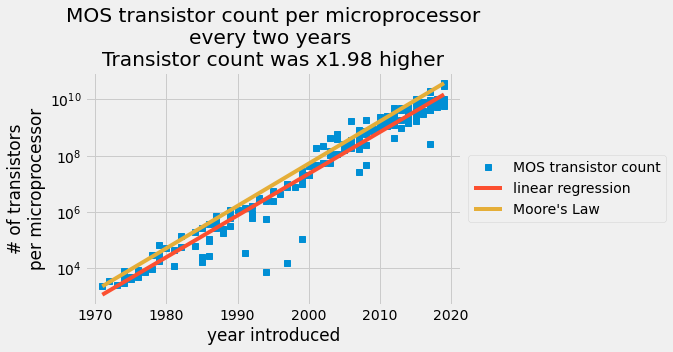

In [13]:
transistor_count_predicted = np.exp(B)*np.exp(A*year)
transistor_Moores_law = Moores_law(year)
plt.style.use('fivethirtyeight')
plt.semilogy(year, transistor_count,'s',label = 'MOS transistor count')
plt.semilogy(year, transistor_count_predicted, label = 'linear regression')


plt.plot(year, transistor_Moores_law, label = 'Moore\'s Law')
plt.title('MOS transistor count per microprocessor\n'+
          'every two years \n'+
          'Transistor count was x{:.2f} higher'.format(np.exp(A*2)))
plt.xlabel('year introduced')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5));
plt.ylabel('# of transistors\nper microprocessor');

The linear regression captures the increase in the number of transistors per semiconductors each year.  In 2015, semiconductor manufacturers claimed they could not keep up with Moore's law anymore. Our analysis shows that since 1971, the average increase in transistor count was x1.98 every 2 years, but Gordon Moore predicted it would would be x2 every 2 years. That is a pretty amazing prediction. 

Let's look at just the year 2017, and compare our linear regression model to Gordon Moore's prediction. First, we need to get all of the transistor counts from the year 2017, we can do this with a Boolean comparator:

`year == 2017`

19200000000.0 250000000.0 7050000000.0


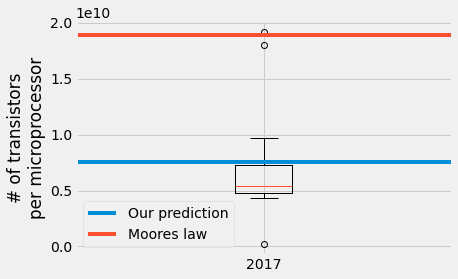

In [14]:
transistor_count2017 = transistor_count[year == 2017]
print(transistor_count2017.max(),transistor_count2017.min(),transistor_count2017.mean())
our_model2017 = np.exp(B)*np.exp(A*2017)
Moore_Model2017 = Moores_law(2017)

plt.boxplot(transistor_count2017,labels = ['2017'])
plt.plot([0.5,1.5],our_model2017*np.ones(2),label = 'Our prediction')
plt.plot([0.5,1.5],Moore_Model2017*np.ones(2), label = 'Moores law')
plt.ylabel('# of transistors\nper microprocessor')
plt.legend()

The result is that our model is very close to the mean, but Gordon Moore's prediction is closer to the maximum number of transistors per microprocessor produced in 2017. Even though semiconductor manufacturers thought that the growth would slow, once in 1975 and again in 2015, we are still producing semiconductors every 2 years that double the number of transistors per microprocessor and on average the result is slightly less, $\times1.98$. 

The linear regression model will do a much better job at predicting the average than extreme values because it satisfies the condition that $\sum |y_i - Ayear[i]+B|^2$ is minimized. 

## Sharing our results as zipped arrays and a csv

The last step in our process is to share our findings. We have created new arrays that represent our linear regression model and Gordon Moore's prediction. We started this process by importing a csv file into a NumPy array using `np.loadtxt`, to save our model we will use two approaches

1. `np.savez` : to save NumPy arrays that can be loaded in other Python sessions
2. `np.savetxt` : to save a csv file with the original data and our predicted data

### Zipping the arrays into a file
Using `np.savez`, we can save multiple arrays and give them names. The function `np.load` will load the arrays back into the workspace as a dictionary. We'll save a few arrays so the next user will have the year, transistor count, predicted transistor count, and Gordon Moore's predicted count. We'll add one more variable that other users can use as a reference for the model, `notes`. 

In [15]:
notes = 'the arrays in this file are the result of a linear regression model\n'
notes += 'the arrays include\nyear: year of manufacture\n'
notes += 'transistor_count: number of transistors reported by manufacturers in a given year\n'
notes += 'transistor_count_predicted: linear regression model = exp({:.2f})*exp({:.2f}*year)\n'.format(B,A)
notes += 'transistor_Moores_law: Moores law =exp({:.2f})*exp({:.2f}*year)\n'.format(B_M,A_M)
notes += 'regression_csts: linear regression constants A and B for log(transistor_count)=A*year+B'
print(notes)

the arrays in this file are the result of a linear regression model
the arrays include
year: year of manufacture
transistor_count: number of transistors reported by manufacturers in a given year
transistor_count_predicted: linear regression model = exp(-666.33)*exp(0.34*year)
transistor_Moores_law: Moores law =exp(-675.38)*exp(0.35*year)
regression_csts: linear regression constants A and B for log(transistor_count)=A*year+B


In [16]:
np.savez('./mooreslaw_regression.npz', notes = notes, 
         year = year, 
        transistor_count = transistor_count, 
        transistor_count_predicted = transistor_count_predicted, 
        transistor_Moores_law = transistor_Moores_law,
        regression_csts = AB)

In [17]:
results = np.load('./mooreslaw_regression.npz')

In [18]:
print(results['regression_csts'][1])

-666.3264063536233


In [19]:
! ls

cs231_tutorial.ipynb      mooreslaw-tutorial.ipynb  Untitled.ipynb
mooreslaw_regression.csv  transistor_data.csv
mooreslaw_regression.npz  tutorial-svd.ipynb


The benefit of `np.savez` is you can save multiple arrays in with different shapes and types. Here, we saved 4 arrays that are double precision floating point numbers shape = `(179,)`, one array that was text, and one array of double precision floating point numbers shape = `(2,).` This is the preferred method for saving NumPy arrays for use in another analysis. 

### Creating our own comma separated value file

If we want to share data with other programs or view the results in a table, it is better to save the data into a text form. We can save the data using `np.savetxt`. This function is much more limited than `np.savez` because it is creating a table of readable text. You can save multiple 1D arrays, but they need to be the same length. 

We prepare the data for export by creating a new 2D array whose columns contain the data of interest. 

We can use the `header` option to describe the data and the columns of the file. Here, we define another variable that contains our file information as `head`.

In [20]:
head = 'the columns in this file are the result of a linear regression model\n'
head += 'the columns include\nyear: year of manufacture\n'
head += 'transistor_count: number of transistors reported by manufacturers in a given year\n'
head += 'transistor_count_predicted: linear regression model = exp({:.2f})*exp({:.2f}*year)\n'.format(B,A)
head += 'transistor_Moores_law: Moores law =exp({:.2f})*exp({:.2f}*year)\n'.format(B_M,A_M)
head += 'year:, transistor_count:, transistor_count_predicted:, transistor_Moores_law:'
print(head)

the columns in this file are the result of a linear regression model
the columns include
year: year of manufacture
transistor_count: number of transistors reported by manufacturers in a given year
transistor_count_predicted: linear regression model = exp(-666.33)*exp(0.34*year)
transistor_Moores_law: Moores law =exp(-675.38)*exp(0.35*year)
year:, transistor_count:, transistor_count_predicted:, transistor_Moores_law:


In order to export columns of data in our csv file, we have to build a single 2D array. Tabular data is inherently two dimensional. We need to organize our data to fit this 2D structure. We use `year`, `transistor_count`, `transistor_count_predicted`, and `transistor_Moores_law` as the first through fourth columns, respectively. We put the calculated constants in the header since they do not fit the `(179,)` shape. The `np.block` function appends arrays together to create a new, larger array. The `np.newaxis` function ensures that each 1D array is treated as a column by giving it a second dimension of length one e.g. 
```python
>>> year.shape
(179,)
>>> year[:,np.newaxis].shape
(179,1)
```

In [21]:
output = np.block([year[:,np.newaxis],
                  transistor_count[:,np.newaxis],
                  transistor_count_predicted[:,np.newaxis],
                  transistor_Moores_law[:,np.newaxis]])

Creating the `mooreslaw_regression.csv` with `np.savetxt`, we use a few options to create the file in our desired format: 
* `X = output` : use our `output` block to write the data into the file
* `delimiter = ','` : use commas to separate columns in the file
* `header = head` : use the header `head` that we defined before

In [22]:
np.savetxt('mooreslaw_regression.csv', 
           X = output,
           delimiter = ',',
          header = head)

In [23]:
! head mooreslaw_regression.csv

# the columns in this file are the result of a linear regression model
# the columns include
# year: year of manufacture
# transistor_count: number of transistors reported by manufacturers in a given year
# transistor_count_predicted: linear regression model = exp(-666.33)*exp(0.34*year)
# transistor_Moores_law: Moores law =exp(-675.38)*exp(0.35*year)
# year:, transistor_count:, transistor_count_predicted:, transistor_Moores_law:
1.971000000000000000e+03,2.250000000000000000e+03,1.130514785642591733e+03,2.249999999999916326e+03
1.972000000000000000e+03,3.500000000000000000e+03,1.590908400344571419e+03,3.181980515339620069e+03
1.973000000000000000e+03,2.500000000000000000e+03,2.238793840142739555e+03,4.500000000000097316e+03


## Wrapping up

In conclusion, we have compared historical data for semiconductor manufacturers to Moore's law and created a linear regression model to find the average number of transistors added to each microprocessor every two years. Gordon Moore predicted the number of transistors would double every two years from 1965 through 1975, but the average growth has maintained a consistent increase of $\times 1.98 \pm 0.01$ every two years from 1971 through 2019. You can share these results as a zipped NumPy array file, `mooreslaw_regression.npz`, or as another csv, `mooreslaw_regression.csv`.  The amazing progress in semiconductor manufacturing has enabled new industries and computational power. This analysis should give you a small insight into how incredible this growth has been over the last half-century. 

## References

1. ["Moore's Law." Wikipedia article. Accessed Oct. 1, 2020.](https://en.wikipedia.org/wiki/Moore%27s_law)
2. [Moore, Gordon E. (1965-04-19). "Cramming more components onto integrated circuits". intel.com. Electronics Magazine. Retrieved April 1, 2020.](https://newsroom.intel.com/wp-content/uploads/sites/11/2018/05/moores-law-electronics.pdf)
3. [Courtland, Rachel. "Gordon Moore: The Man Whose Name Means Progress." IEEE Spectrum. 30 Mar. 2015.](https://spectrum.ieee.org/computing/hardware/gordon-moore-the-man-whose-name-means-progress).
4. ["Transistor Count." Wikipedia article. Accessed Oct. 1, 2020.](https://en.wikipedia.org/wiki/Transistor_count#Microprocessors)